In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# loading data...
airbnb_df = pd.read_csv("airbnb_data_clean.csv")

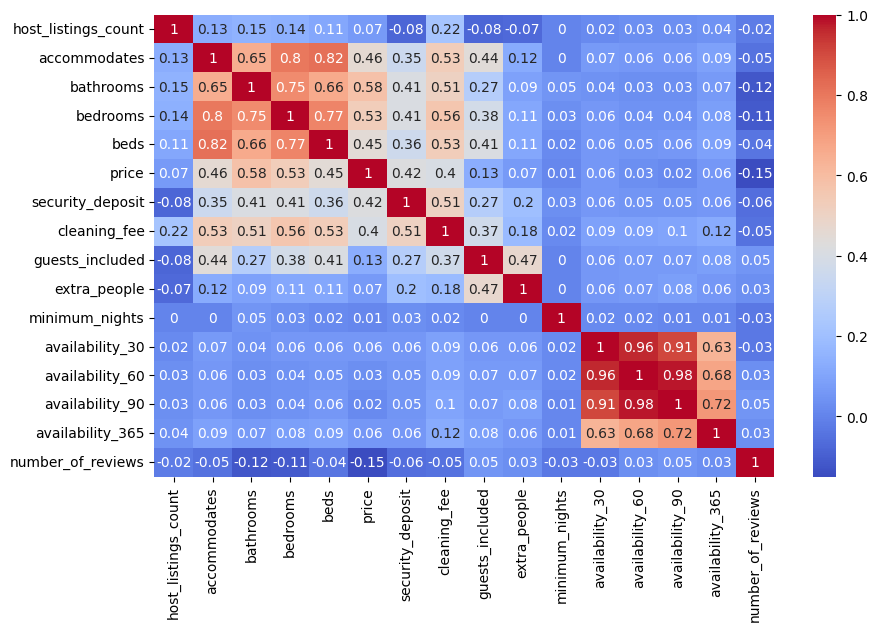

In [ ]:
airbnb_df_num = airbnb_df.drop(columns=['host_is_superhost', 'neighbourhood', 'property_type', 'room_type','bed_type', 'has_availability', 'instant_bookable', 'cancellation_policy'])

# Compute correlations
cormat = airbnb_df_num.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,6))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

I am going to remove from this date frame all of the numeric variables that have less than 0.2 absolute correlation with price. It seems that these variables really have nothing to do with price.

In [ ]:
# dropping irrelevant variables
airbnb_df = airbnb_df.drop(columns=['host_listings_count','guests_included','extra_people','minimum_nights','availability_30','availability_60','availability_90','availability_365','number_of_reviews'])

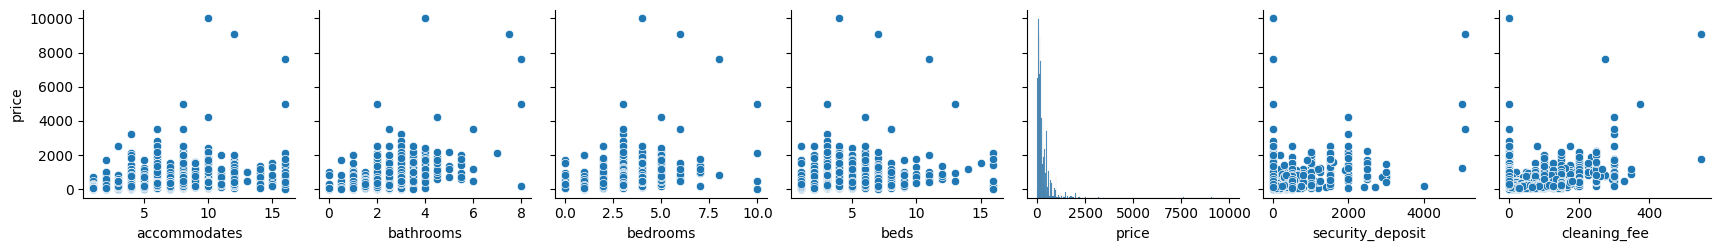

In [ ]:
# plot graphs of x-y relationships
sns.pairplot(airbnb_df,
             x_vars=['accommodates','bathrooms','bedrooms','beds','price','security_deposit','cleaning_fee'],
             y_vars="price")
plt.show()

It seems like we have a few outliers for price. I'm going to remove those outliers from our data. I'm going to remove any price that exceeds 4000, which is several standard deviations above the mean for our dataset.


In [ ]:
print(airbnb_df['price'].describe())


count     4751.000000
mean       296.678804
std        402.341382
min          0.000000
25%        100.000000
50%        180.000000
75%        350.000000
max      10000.000000
Name: price, dtype: float64


I'm also going to remove any airbnbs with a price of zero, because that would just be free. Doesn't make much sense to list a place on airbnb for free.

In [ ]:
airbnb_df = airbnb_df[airbnb_df['price'] < 4000]
airbnb_df = airbnb_df[airbnb_df['price'] > 0]

In [ ]:
airbnb_df.shape

(4744, 15)

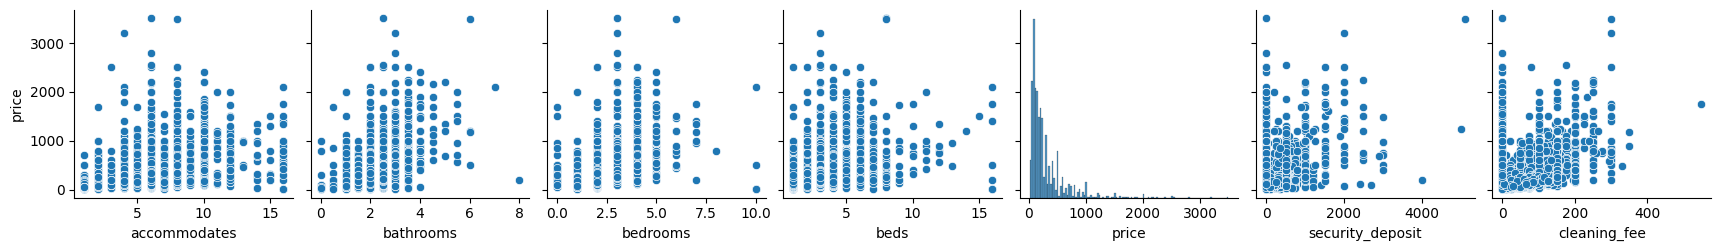

In [ ]:
# plot graphs of x-y relationships
sns.pairplot(airbnb_df,
             x_vars=['accommodates','bathrooms','bedrooms','beds','price','security_deposit','cleaning_fee'],
             y_vars="price")
plt.show()

This data looks heavily skewed to the right, from a y-variable standpoint.

In [ ]:
# Convert the boolean values to 1/0 for neighbourhood dummies
X1 = airbnb_df[['accommodates', 'bedrooms', 'beds', 
               'security_deposit', 'cleaning_fee']]
X1 = pd.concat([X1, pd.get_dummies(airbnb_df[['host_is_superhost', 'neighbourhood', 'property_type', 'room_type','bed_type', 'has_availability', 'instant_bookable', 'cancellation_policy']], drop_first=True)], axis=1)

# Convert any boolean values in X1 to numeric (1/0)
X1 = X1.astype(int)

# Add constant term
X2 = sm.add_constant(X1)

# Log-transform the dependent variable
y = airbnb_df['price']

# Perform linear regression
reg1 = sm.OLS(y, X2).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     35.54
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:15:45   Log-Likelihood:                -32617.
No. Observations:                4744   AIC:                         6.546e+04
Df Residuals:                    4631   BIC:                         6.619e+04
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [ ]:
def stepwise_selection(X, y, threshold_in=0.01, threshold_out=0.025):
    """
    Perform stepwise regression.
    X: Independent variables (including dummies)
    y: Dependent variable
    threshold_in: p-value to enter a variable into the model
    threshold_out: p-value to remove a variable from the model
    """
    initial_features = X.columns.tolist()
    while True:
        # Fit the model
        model = sm.OLS(y, sm.add_constant(X[initial_features])).fit()

        # Get the p-values of all the features
        p_values = model.pvalues[1:]  # Ignore the constant's p-value

        # Get the feature with the highest p-value
        max_p_value = p_values.max()
        if max_p_value >= threshold_out:
            # Remove the feature with the highest p-value if it's above the threshold
            excluded_feature = p_values.idxmax()
            initial_features.remove(excluded_feature)
        else:
            # If all p-values are below the threshold, stop
            break

    # Return the selected features and the fitted model
    selected_features = initial_features
    final_model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
    return selected_features, final_model

# Specify the independent and dependent variables
X1 = airbnb_df[['accommodates', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee']]
X1 = pd.concat([X1, pd.get_dummies(airbnb_df[['host_is_superhost', 'neighbourhood', 'property_type', 'room_type','bed_type', 'has_availability', 'instant_bookable', 'cancellation_policy']], drop_first=True)], axis=1)

# Convert any boolean values in X1 to numeric (1/0)
X1 = X1.astype(int)

# Dependent variable
y = airbnb_df['price']

# Perform stepwise selection
selected_features, final_model = stepwise_selection(X1, y)

# Print the selected features and model summary
print(final_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     122.0
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:17:38   Log-Likelihood:                -32656.
No. Observations:                4744   AIC:                         6.538e+04
Df Residuals:                    4711   BIC:                         6.559e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [ ]:
def stepwise_selection(X, y, threshold_in=0.01, threshold_out=0.025):
    """
    Perform stepwise regression.
    X: Independent variables (including dummies)
    y: Dependent variable
    threshold_in: p-value to enter a variable into the model
    threshold_out: p-value to remove a variable from the model
    """
    initial_features = X.columns.tolist()
    while True:
        # Fit the model
        model = sm.OLS(y, sm.add_constant(X[initial_features])).fit()

        # Get the p-values of all the features
        p_values = model.pvalues[1:]  # Ignore the constant's p-value

        # Get the feature with the highest p-value
        max_p_value = p_values.max()
        if max_p_value >= threshold_out:
            # Remove the feature with the highest p-value if it's above the threshold
            excluded_feature = p_values.idxmax()
            initial_features.remove(excluded_feature)
        else:
            # If all p-values are below the threshold, stop
            break

    # Return the selected features and the fitted model
    selected_features = initial_features
    final_model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
    return selected_features, final_model

# Specify the independent and dependent variables
X1 = airbnb_df[['accommodates', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee']]
X1 = pd.concat([X1, pd.get_dummies(airbnb_df[['host_is_superhost', 'neighbourhood', 'property_type', 'room_type','bed_type', 'has_availability', 'instant_bookable', 'cancellation_policy']], drop_first=True)], axis=1)

# Convert any boolean values in X1 to numeric (1/0)
X1 = X1.astype(int)

# Dependent variable
y = np.log(airbnb_df['price'])

# Perform stepwise selection
selected_features, final_model = stepwise_selection(X1, y)

# Print the selected features and model summary
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     164.6
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:17:41   Log-Likelihood:                -3971.0
No. Observations:                4744   AIC:                             8030.
Df Residuals:                    4700   BIC:                             8314.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

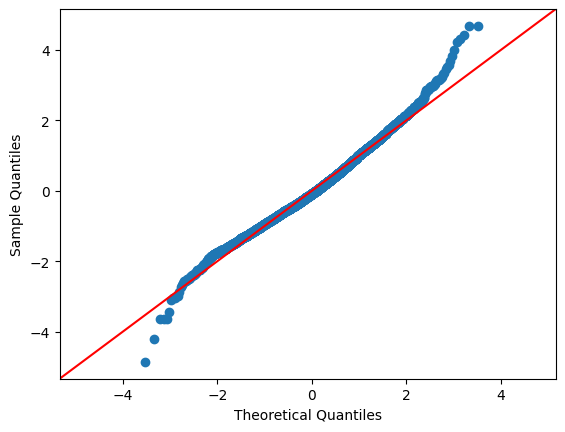

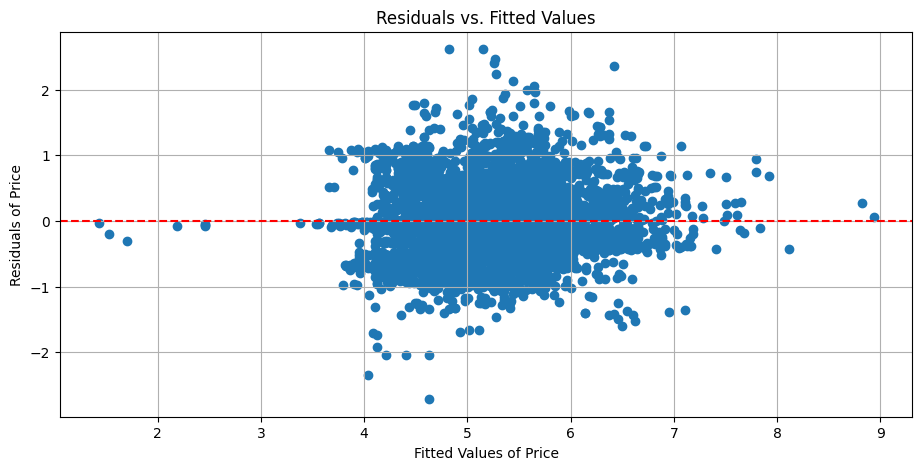

In [ ]:
# Calculate residuals
residuals = final_model.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(11, 5))
plt.scatter(final_model.fittedvalues, residuals)
plt.xlabel('Fitted Values of Price')
plt.ylabel('Residuals of Price')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()